#### Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import pathlib
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import librosa
import librosa.display
from pyts.image import GASF, GADF, MTF, RecurrencePlots

#### Download dataset

In [4]:
path = pathlib.Path.home()/'.fastai/data/kaggle_earthquake'

In [5]:
! mkdir -p $path;
! kaggle competitions download -c LANL-Earthquake-Prediction -p $path
! cd $path; if [ ! -f train.csv ]; then unzip -n -q train.csv.zip; fi
! cd $path; if [ ! -d test ]; then unzip -n -q test.zip; mkdir test; mv seg* test; fi

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
os.listdir(path)

['sample_submission.csv',
 'test.zip',
 'train.csv.zip',
 'train.csv',
 'train',
 'X_train.csv',
 'y_train.csv',
 'train_images',
 'test']

#### Load training data
Estimated time: 3 min

In [7]:
rows = 150_000
train = pd.read_csv(path/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [8]:
segments = int(np.floor(train.shape[0] / rows))
segments

4194

In [9]:
pd.options.display.precision = 15

In [10]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


#### Write out per segement csv for training set
Estimated time: 15 min

In [11]:
train_path = path/'train'
# assume if the dir exists then all the files are there
if not os.path.isdir(train_path):
    os.mkdir(train_path)
        
    for n in tqdm(range(segments)):
        seg = train.iloc[n*rows:n*rows+rows]['acoustic_data']
        seg.to_csv(train_path/f'seg_{n}.csv', header='acoustic_data', index=False)

100%|██████████| 4194/4194 [16:21<00:00,  4.31it/s]


In [12]:
len(os.listdir(train_path))

4194

#### Create per segment features

In [13]:
X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

In [14]:
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()

100%|██████████| 4194/4194 [00:08<00:00, 476.19it/s]


In [15]:
X_train.head()

,ave,std,max,min
0,4.884113333333334,5.101089126891323,104.0,-98.0
1,4.725766666666667,6.588801819164257,181.0,-154.0
2,4.906393333333333,6.967373808828945,140.0,-106.0
3,4.902240000000000,6.922282112791032,197.0,-199.0
4,4.908720000000000,7.301085852684289,145.0,-126.0


In [16]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


In [22]:
# plot histogram of training set
def plot_histogram(targs):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
    ax1.hist(targs, bins=100); ax1.set_xlabel('targs TTF'); ax1.set_ylabel('No. of segments')
    ax2.plot(targs); ax2.set_xlabel('segment'); ax1.set_ylabel('TTF')

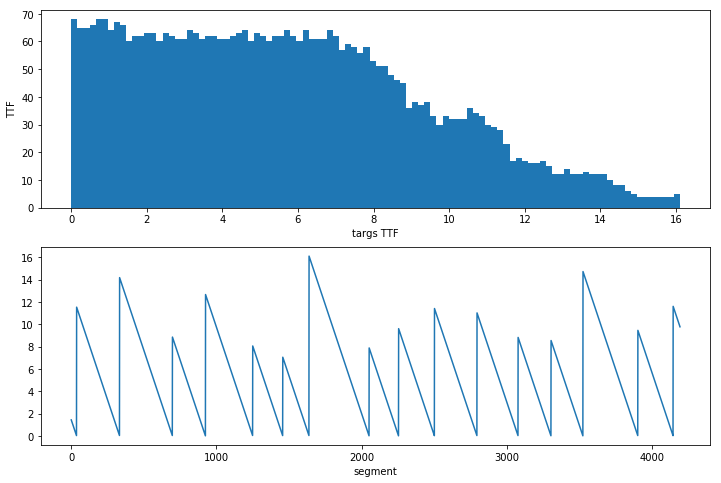

In [23]:
plot_histogram(np.array(y_train['time_to_failure']))

#### Write out per segment CSVs

In [19]:
X_train.to_csv(path/'X_train.csv')

In [20]:
y_train.to_csv(path/'y_train.csv')

#### Visualize acoustic data and spectrogram

In [24]:
# actual sample rate is 4_000_000
sample_rate = 40000

In [25]:
def plot_segment(segment):
    seg = train.iloc[segment*rows:segment*rows+rows]['acoustic_data']
    plt.figure()
    
    plt.subplot(2, 1, 1)
    plt.plot(seg)
    
    plt.subplot(2, 1, 2)
    seg = np.array(seg, dtype=np.float)
    S = librosa.feature.melspectrogram(y=seg, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sample_rate, y_axis='linear', x_axis='time')
    #plt.colorbar(format='%+2.0f dB')

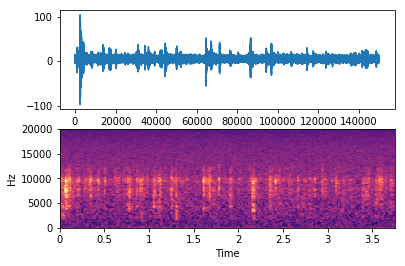

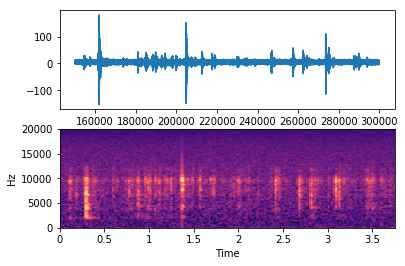

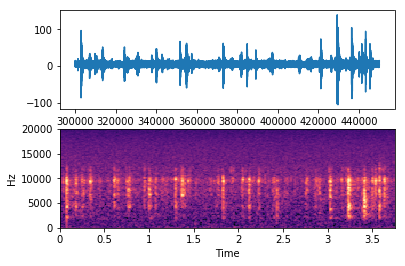

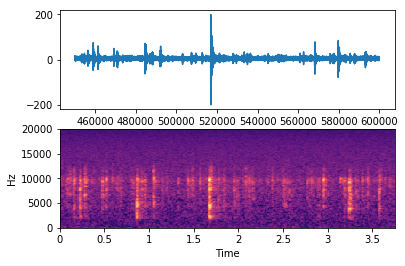

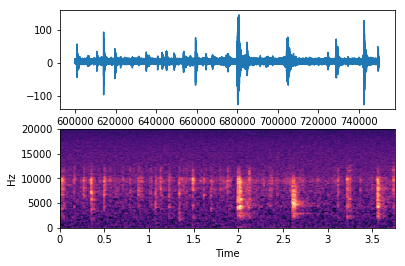

In [115]:
for i in range(5):
    plot_segment(i)

(128, 384)


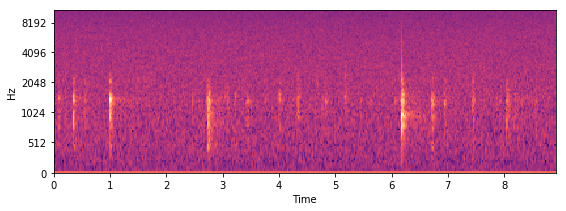

In [75]:
# generate single spectrogram
transform = 'mel'

# load segment
segment = 'seg_38.csv'
seg = pd.read_csv(path/f'train/{segment}', squeeze=True)
seg = np.array(seg, dtype=np.float)

# create figure
fig = plt.figure(figsize=[9, 3])
ax = fig.add_subplot(111)

# do mel transform
if transform == 'mel':
    #sample_rate = 40000
    n_fft = 766       # y
    hop_length = 391  # x
    mel_power = librosa.feature.melspectrogram(y=seg, n_fft=n_fft, hop_length=hop_length)
    mel_power_db = librosa.power_to_db(mel_power, ref=np.max)
    librosa.display.specshow(mel_power_db, ax=ax, y_axis='mel', x_axis='time')
    print(mel_power_db.shape)


# do short time fourier transform
# values chosen to generate a 384x384 size image
if transform == 'stft':
    n_fft = 766       # y
    hop_length = 391  # x
    stft = librosa.stft(y=seg, n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, stft_phase = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    librosa.display.specshow(stft_magnitude_db, ax=ax, y_axis='linear', x_axis='time')
    print(stft_magnitude_db.shape)


# Image generation helper functions

In [68]:
def create_images_from_segment(segment, input_path):
    #transforms = ['mel', 'gadf', 'gasf']
    transforms = ['mel']
    
    # load segment
    seg = pd.read_csv(input_path/f'{segment}', squeeze=True)
    seg = np.array(seg, dtype=np.float)
        
    for transform in transforms:
        # create plot
        fig = plt.figure(figsize=[4.96, 5.09/3])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)

        # generate stft spectrogram
        if transform == 'stft':
            # generates a 384x384 size image
            n_fft = 766       # y
            hop_length = 391  # x
            stft = librosa.stft(y=seg, n_fft=n_fft, hop_length=hop_length)
            stft_magnitude, stft_phase = librosa.magphase(stft)
            stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
            librosa.display.specshow(stft_magnitude_db, ax=ax)

        # generate mel spectrogram
        if transform == 'mel':
            # generates a 128x384 size image
            n_fft = 766       # y
            hop_length = 391  # x
            mel_power = librosa.feature.melspectrogram(y=seg, n_fft=n_fft, hop_length=hop_length)
            mel_power_db = librosa.power_to_db(mel_power, ref=np.max)
            librosa.display.specshow(mel_power_db, ax=ax)
            
        # generate gramian angular difference field
        if transform == 'gadf':
            image_size = 384
            gadf = GADF(image_size)
            img = gadf.fit_transform(seg.reshape(1, -1)).squeeze()
            ax.imshow(img, cmap='viridis', origin='lower')

        # generate gramian angular summation field
        if transform == 'gasf':
            image_size = 384
            gasf = GASF(image_size)
            img = gasf.fit_transform(seg.reshape(1, -1)).squeeze()
            ax.imshow(img, cmap='rainbow', origin='lower')

        # generate markov transition field
        # TODO: fix this, throwing MemoryError
        if transform == 'mtf':
            mtf = MTF(16)
            img = mtf.fit_transform(seg.reshape(1, -1)).squeeze()
            ax.imshow(img, cmap='magma', origin='lower')
            
        # save image
        output_path = pathlib.Path(f'{input_path}_images/{transform}')
        os.makedirs(output_path, exist_ok=True)
        plt.savefig(output_path/f'{segment}'.replace('.csv', '.png'), dpi=100, bbox_inches='tight', pad_inches=0)
        #plt.show()
        plt.close('all')

#### Generate an image for each segment in training set
Estimated time: 45 min

In [70]:
train_path = path/'train'
segments = os.listdir(train_path)
for segment in tqdm(segments):
    create_images_from_segment(segment, train_path)

100%|██████████| 4194/4194 [16:10<00:00,  4.63it/s] 


#### Generate an image for each segment in test set
Estimated time: 30 min

In [71]:
test_path = path/'test'
segments = os.listdir(test_path)
for segment in tqdm(segments):
    create_images_from_segment(segment, test_path)

100%|██████████| 2624/2624 [10:09<00:00,  4.57it/s] 


## IDEAS

#### Consider tempo and beat times as features

In [ ]:
tempo, beat_frames = librosa.beat.beat_track(y=seg1)
beat_times = librosa.frames_to_time(beat_frames)

#### Set correct sample rate at 4MHz

In [ ]:
sample_rate = 4_000_000
segment = 0
seg = train.iloc[segment*rows:segment*rows+rows]['acoustic_data']
seg = np.array(seg, dtype=np.float)
S = librosa.feature.melspectrogram(y=seg, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sample_rate, y_axis='linear', x_axis='time')

In [ ]:
S.shape

Throws this errror:
```
/anaconda3/envs/fastai/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
```

#### Use different type of spectrogram more suited to seiesmology

#### Visualize raw acoustic data

In [ ]:
for segment in range(5):
    seg = train.iloc[segment*rows:segment*rows+rows]['acoustic_data']
    plt.figure()
    plt.plot(seg)

#### Visualize spectrogram

In [ ]:
# actual sample rate is 4_000_000
sample_rate = 40_000
for segment in range(5):
    seg = train.iloc[segment*rows:segment*rows+rows]['acoustic_data']
    seg = np.array(seg, dtype=np.float)
    S = librosa.feature.melspectrogram(y=seg, sr=sample_rate)
    plt.figure()
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sample_rate, y_axis='linear', x_axis='time')

#### Old image generation code for train dataset

In [ ]:
for segment in tqdm(range(segments)):
    # generate plot
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    # generate spectrogram
    seg = train.iloc[segment*rows:segment*rows+rows]['acoustic_data']
    seg = np.array(seg, dtype=np.float)
    S = librosa.feature.melspectrogram(y=seg, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sample_rate)
    # save file
    plt.savefig(img_path/f'seg_{segment}.png', dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close('all')

#### Old resize code

In [ ]:
# pre-resize images to match model input
def resize_images(input_path, output_path, size):
    # create dir
    os.makedirs(output_path, exist_ok=True)
    # duplicate files
    files = os.listdir(input_path)
    for file in files:
        shutil.copyfile(input_path/file, output_path/file)
    # resize with mogrify
    ! cd $output_path; mogrify -resize $size -gravity center -extent $size *png